<a href="https://colab.research.google.com/github/pascale25/YbtO9JT8miFZIZdm/blob/master/Potential__Talents.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Background:

As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.

##  Data Description:

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

Attributes:

- id : unique identifier for candidate (numeric)

- job_title : job title for candidate (text)

- location : geographical location for candidate (text)

- connections: number of connections candidate has, 500+ means over 500 (text)

- Output (desired target):
fit - how fit the candidate is for the role? (numeric, probability between 0-1)

Keywords: “Aspiring human resources” or “seeking human resources”


Goal(s):

Predict how fit the candidate is based on their available information (variable fit)

Success Metric(s):

Rank candidates based on a fitness score.

Re-rank candidates when a candidate is starred.

Bonus(es):

We are interested in a robust algorithm, tell us how your solution works and show us how your ranking gets better with each starring action.

How can we filter out candidates which in the first place should not be in this list?

Can we determine a cut-off point that would work for other roles without losing high potential candidates?

Do you have any ideas that we should explore so that we can even automate this procedure to prevent human bias?

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#!pip install --upgrade gensim

In [ ]:
!pip install -U sentence-transformers

In [ ]:
!pip install fasttext

# 0. Import libraries

In [240]:
import nltk
import string
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('omw-1.4')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import seaborn as sns
import re
import os
import pickle 
#import mglearn
import time
# gensim
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.test.utils import get_tmpfile
from gensim.models import KeyedVectors, Word2Vec   
from gensim.scripts.glove2word2vec import glove2word2vec
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
# scipy
from scipy.spatial.distance import cosine
import spacy

from multiprocessing import cpu_count
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer

from nltk.tokenize import TweetTokenizer # doesn't split at apostrophes
import nltk
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [241]:

## Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [242]:
## Display all rows and columns of a dataframe instead of a truncated version
from IPython.display import display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [243]:
import gensim
gensim.__version__

'3.6.0'

# Get the data 

In [244]:
os.listdir("gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J")

['Potential _Talents.ipynb',
 'glove.6B.50d.txt',
 'Copy of potential-talents.gsheet',
 'potential-talents.csv',
 'glove.6B.50d.txt.zip',
 'NLP_vectors.ipynb',
 'gensim-word2vec-tutorial.ipynb',
 'GoogleNews-vectors-negative300.bin.gz',
 'cc.en.300.bin',
 'Potential_Talents_playground_NLP.ipynb',
 'word2vec_model']

In [245]:
data = "gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/potential-talents.csv"

In [246]:
# read data 
df = pd.read_csv(data)
df.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [247]:
# check the shape, Null value
print(df.shape)
print('................................................')
print(df.isna().sum())
print('................................................')
print(df.info())

(104, 5)
................................................
id              0
job_title       0
location        0
connection      0
fit           104
dtype: int64
................................................
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB
None


In [248]:
df.duplicated().sum()

0

In [249]:
df.columns

Index(['id', 'job_title', 'location', 'connection', 'fit'], dtype='object')

In [250]:
df.location.unique()

array(['Houston, Texas', 'Kanada', 'Raleigh-Durham, North Carolina Area',
       'Denton, Texas', 'İzmir, Türkiye', 'Greater New York City Area',
       'San Francisco Bay Area', 'Greater Philadelphia Area',
       'Lake Forest, California', 'Houston, Texas Area',
       'Atlanta, Georgia', 'Chicago, Illinois', 'Austin, Texas Area',
       'Jackson, Mississippi Area', 'Greater Grand Rapids, Michigan Area',
       'Virginia Beach, Virginia', 'Monroe, Louisiana Area',
       'Greater Boston Area', 'San Jose, California',
       'New York, New York', 'Dallas/Fort Worth Area',
       'Amerika Birleşik Devletleri', 'Baton Rouge, Louisiana Area',
       'Myrtle Beach, South Carolina Area', 'Chattanooga, Tennessee Area',
       'Los Angeles, California', 'Highland, California',
       'Gaithersburg, Maryland', 'Baltimore, Maryland',
       'Milpitas, California', 'Greater Atlanta Area',
       'Greater Chicago Area', 'Torrance, California',
       'Long Beach, California', 'Bridgewater, Massa

In [251]:
len(df.location.unique())

41

In [252]:
df.connection.unique()

array(['85', '500+ ', '44', '1', '61', '2', '390', '57', '82', '5', '7',
       '16', '212', '409', '52', '455', '174', '268', '50', '4', '40',
       '18', '349', '155', '39', '64', '9', '415', '19', '71', '48',
       '103', '49'], dtype=object)

In [253]:
len(df.connection.unique())

33

In [254]:
# replace 500+ part 501
df[df['connection'] == '500+ ']

,id,job_title,location,connection,fit
1,2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN
7,8,HR Senior Specialist,San Francisco Bay Area,500+,NaN
9,10,Seeking Human Resources HRIS and Generalist Po...,Greater Philadelphia Area,500+,NaN
11,12,"SVP, CHRO, Marketing & Communications, CSR Off...","Houston, Texas Area",500+,NaN
12,13,Human Resources Coordinator at InterContinenta...,"Atlanta, Georgia",500+,NaN
15,16,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
17,18,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
19,20,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN


In [255]:
3 #replacing 500+ value with 501 and convert to numerique data type
df.replace('500+ ','501', inplace=True)

3

In [256]:
df['connection'] = pd.to_numeric(df['connection'])

The dataset consists of 104 observations and has 3 features, including one numerical feature and two text-based features. The dataset is cleaned and has no duplicate or missing values. Also, values of "500+" are replaced with "501" and converted to numerical format.

# EDA on connection variable

<Figure size 720x504 with 0 Axes>

Text(26.0, 29, '29\n')

Text(76.0, 20, '20\n')

Text(126.0, 1, '1\n')

Text(176.0, 2, '2\n')

Text(226.0, 1, '1\n')

Text(276.0, 1, '1\n')

Text(326.0, 1, '1\n')

Text(376.0, 2, '2\n')

Text(426.0, 2, '2\n')

Text(476.0, 45, '45\n')

Text(0.5, 1.0, 'Number of connections histogram')

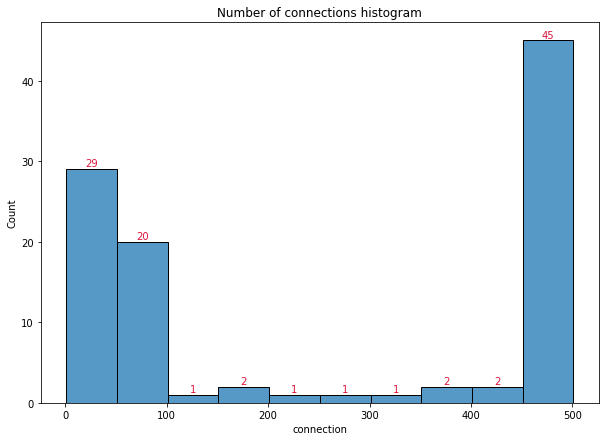

In [257]:
#df.head(2) 
plt.figure(figsize = [10 ,7])
ax = sns.histplot(data = df, x='connection', bins = 10)
# iterate over the patches belonging to the ax, get their position and height and use these to create annotations.
for p in ax.patches:
    ax.annotate(f'{p.get_height():.0f}\n',
                (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color='crimson')
plt.title("Number of connections histogram")
plt.show()

The "connection feature" has 33 unique values. A histogram plot reveals that the highest frequency is found in the bin of 450 to 501, with 45 out of 103 observations. This is followed by the bin of 0-50, with 29 out of 103 observations and the bin of 50-100 with 20 out of 103 observations.

# EDA on Jobs Title variable 

we define a function to 
- remove punctuation and special characters
- lowercase
- split into tokens 
- remove numbers
- and lemmatize words
- delete all words with less than 3 letters.


In [258]:
# define a function for text preparation (cleanning)
#string.punctuation
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
stopword = stopwords.words('english')
#text = [wn.lemmatize(word) for word in tokens if word not in stopword] # stemming
def clean_text(text):
  """  remove special caracter, lower case , remove digit, split into token"""
  text = "".join([word.lower() for word in text if word not in string.punctuation])
  tokens = re.split('\W+', text)
  # remove words that contain numbers
  text = [word for word in text if not any(c.isdigit() for c in word)]
  return tokens

In [259]:
#df['job_clean'] = df['job_title'].apply(lambda row: clean_text(row))
#df['location_clean'] = df['location'].apply(lambda row: clean_text(row))

In [260]:
df.head(2)

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Progra...,Kanada,501,NaN


In [261]:
wn = nltk.WordNetLemmatizer()
def clean_text_lem(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    tokens = [t for t in tokens if t.isalpha()] # remove numeric 
    tokens = [word for word in tokens if not any(c.isdigit() for c in word)]                      
    text = [wn.lemmatize(word) for word in tokens if word not in stopword] # lemmatize and remove stopword 
    # remove empty tokens and tokens of 1 or 2 letters 
    text = [t for t in text if len(t) > 2]
    # join all
    #text = " ".join(text)
    return text

In [262]:
job = df.job_title[0]
job

'2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional'

In [263]:
clean_text(job)

['2019',
 'ct',
 'bauer',
 'college',
 'of',
 'business',
 'graduate',
 'magna',
 'cum',
 'laude',
 'and',
 'aspiring',
 'human',
 'resources',
 'professional']

In [264]:
clean_text_lem(job)

['bauer',
 'college',
 'business',
 'graduate',
 'magna',
 'cum',
 'laude',
 'aspiring',
 'human',
 'resource',
 'professional']

In [265]:
df['job_clean_lem'] = df['job_title'].apply(lambda row: clean_text_lem(row))
df['location_clean_lem'] = df['location'].apply(lambda row: clean_text_lem(row))

In [266]:
df.head(2)

,id,job_title,location,connection,fit,job_clean_lem,location_clean_lem
0,1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN,"[bauer, college, business, graduate, magna, cu...","[houston, texas]"
1,2,Native English Teacher at EPIK (English Progra...,Kanada,501,NaN,"[native, english, teacher, epik, english, prog...",[kanada]


In [267]:
df['job_clean_lem'].head(5)

0    [bauer, college, business, graduate, magna, cu...
1    [native, english, teacher, epik, english, prog...
2            [aspiring, human, resource, professional]
3             [people, development, coordinator, ryan]
4    [advisory, board, member, celal, bayar, univer...
Name: job_clean_lem, dtype: object

In [268]:
# Import Counter
#from collections import Counter 
# Create a Counter with the lowercase tokens (it is a bag of word of clean job lem)
BOW_jobs = df['job_clean_lem'].apply(lambda row: Counter(row)) 
BOW_jobs.head(5)

0    {'bauer': 1, 'college': 1, 'business': 1, 'gra...
1    {'native': 1, 'english': 2, 'teacher': 1, 'epi...
2    {'aspiring': 1, 'human': 1, 'resource': 1, 'pr...
3    {'people': 1, 'development': 1, 'coordinator':...
4    {'advisory': 1, 'board': 1, 'member': 1, 'cela...
Name: job_clean_lem, dtype: object

In [269]:
count_jobs=[]

for row in df['job_clean_lem']:
    for word in row:
        count_jobs.append(word)
        
jobs_counts=Counter(count_jobs)
print('number of unique word in the genre is', len (jobs_counts)) # get all the word use in Genres and count the number 

# Print the 10 most common tokens
print(jobs_counts.most_common(10))

number of unique word in the genre is 170
[('human', 63), ('resource', 63), ('aspiring', 35), ('professional', 21), ('student', 16), ('seeking', 15), ('college', 14), ('generalist', 14), ('university', 12), ('specialist', 12)]


In [270]:
df_job = pd.DataFrame(dict(jobs_counts), index = [0]).T.sort_values(by = 0)
df_job = df_job.rename(columns = {0: 'count_jobs_title'})
df_job.tail(5)

,count_jobs_title
student,16
professional,21
aspiring,35
resource,63
human,63


<Figure size 720x576 with 0 Axes>

Text(0.5, 1.0, '20 Top job title words')

Text(0.5, 0, 'count')

Text(0, 0.5, 'job title')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

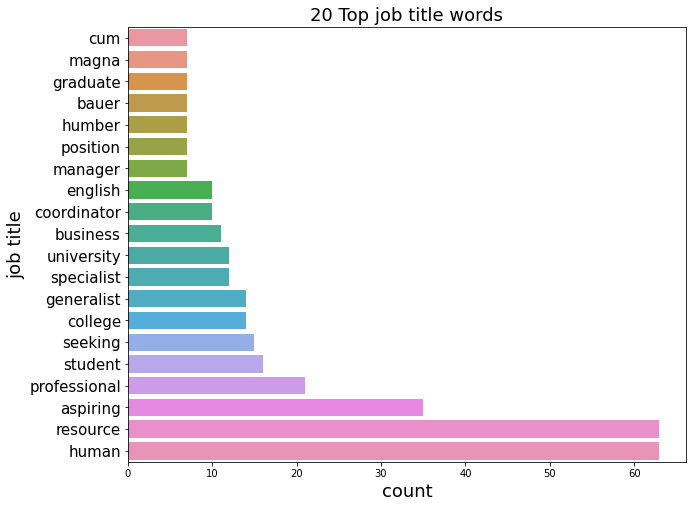

In [271]:
# dict(genres_counts) convert to dictionary
dfg = df_job.tail(20)
plt.figure(figsize = (10,8))
sns.barplot(data = dfg, y= dfg.index, x='count_jobs_title')
plt.title('20 Top job title words', fontsize =18)
plt.xlabel('count', fontsize =18)
plt.ylabel('job title', fontsize =18)
plt.yticks(fontsize=15)
plt.show()

The plot reveal that Human, ressource, aspiging are the most commont words found in Jobs Title

In [272]:
#from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#from PIL import Image

In [273]:
count_jobs[:9]

['bauer',
 'college',
 'business',
 'graduate',
 'magna',
 'cum',
 'laude',
 'aspiring',
 'human']

In [274]:
all_words_joined = ' '.join(count_jobs)
all_words_joined

'bauer college business graduate magna cum laude aspiring human resource professional native english teacher epik english program korea aspiring human resource professional people development coordinator ryan advisory board member celal bayar university aspiring human resource specialist student humber college aspiring human resource generalist senior specialist student humber college aspiring human resource generalist seeking human resource hris generalist position student chapman university svp chro marketing communication csr officer engie houston woodland energy gphr sphr human resource coordinator intercontinental buckhead atlanta bauer college business graduate magna cum laude aspiring human resource professional bauer college business graduate magna cum laude aspiring human resource professional native english teacher epik english program korea aspiring human resource professional people development coordinator ryan bauer college business graduate magna cum laude aspiring human 

In [275]:
def generate_show_wordcloud(tokens):
    plt.figure(figsize = (15, 15), facecolor = None) 
    wordcloud = WordCloud(width = 1600, height = 1000, 
                background_color ='white', 
                stopwords = STOPWORDS, 
                min_font_size = 10).generate(tokens)
    #plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title('jobs title analysis', fontsize = 20)
    plt.show()

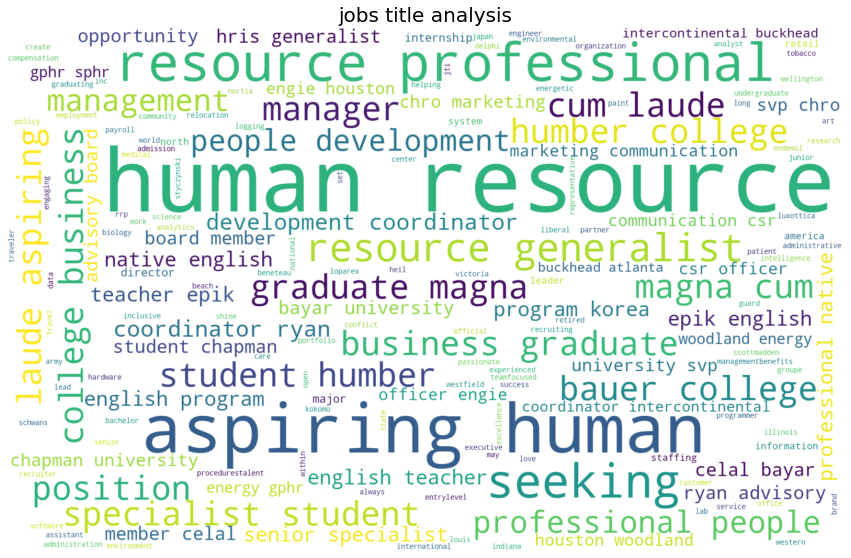

In [276]:
# plot the WordCloud image
generate_show_wordcloud(all_words_joined)

the job title feature

we build a dictionary where we count each word and plot the histogram of the 20 most common words. the top 5 are: Human, Resource, Aspiring, Professional and Student. 

# EDA on location variable

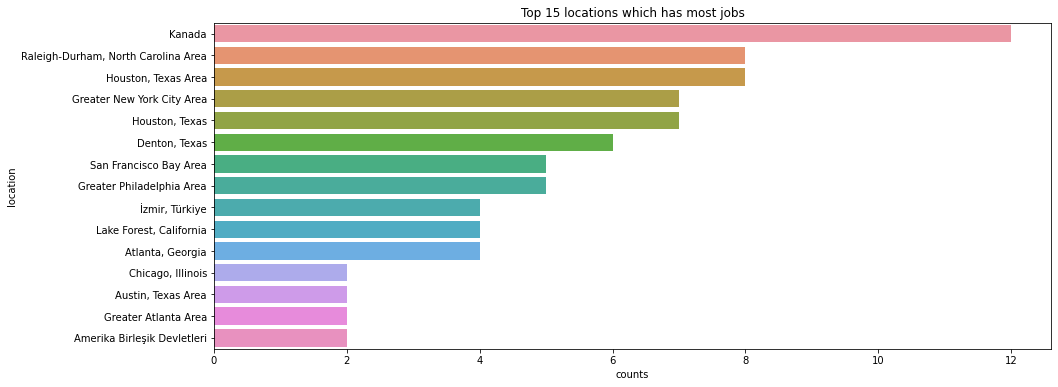

In [277]:
# Country with most numbers of title
plt.figure(figsize=(15,6))
top_locations = df['location'].value_counts().rename_axis('location').reset_index(name = 'counts')[:15]

sns.barplot(data = top_locations, x='counts', y ='location')
plt.title('Top 15 locations which has most jobs');

In [278]:
BOW_location = df['location_clean_lem'].apply(lambda row: Counter(row)) 
BOW_location.head(5)

0                           {'houston': 1, 'texas': 1}
1                                        {'kanada': 1}
2    {'raleighdurham': 1, 'north': 1, 'carolina': 1...
3                            {'denton': 1, 'texas': 1}
4                            {'zmir': 1, 'türkiye': 1}
Name: location_clean_lem, dtype: object

In [279]:
df['location_clean_lem'].head(10)

0                          [houston, texas]
1                                  [kanada]
2    [raleighdurham, north, carolina, area]
3                           [denton, texas]
4                           [zmir, türkiye]
5          [greater, new, york, city, area]
6                                  [kanada]
7               [san, francisco, bay, area]
8                                  [kanada]
9             [greater, philadelphia, area]
Name: location_clean_lem, dtype: object

In [280]:
# converting the location data: Kanada to Canada
#location_replacer = {'kanada': 'canada'}
#talents_df['location'] = talents_df['location'].str.split().apply(lambda x: ' '.join([location_replacer.get(w, w) for w in x]))
#talents_df.head(10

In [281]:
count_location=[]

for row in df['location_clean_lem']:
    for word in row:
        count_location.append(word)

location_counts=Counter(count_location)
print('number of unique word in the genre is', len(location_counts)) # get all the word use in Genres and count the number 

# Print the 10 most common tokens
print(location_counts.most_common(10))

number of unique word in the genre is 68
[('area', 49), ('texas', 24), ('greater', 18), ('houston', 15), ('kanada', 12), ('california', 10), ('carolina', 9), ('new', 9), ('york', 9), ('raleighdurham', 8)]


In [282]:
dict_location = dict(location_counts)
dict_location.pop('area')

49

In [283]:
df_location = pd.DataFrame(dict_location, index = [0]).T.sort_values(by = 0)
df_location = df_location.rename(columns = {0: 'count_location'})
df_location.tail(10)

,count_location
north,8
raleighdurham,8
new,9
carolina,9
york,9
california,10
kanada,12
houston,15
greater,18
texas,24


<Figure size 720x576 with 0 Axes>

Text(0.5, 1.0, '20 Top job title words')

Text(0.5, 0, 'count')

Text(0, 0.5, 'job title')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]), <a list of 20 Text major ticklabel objects>)

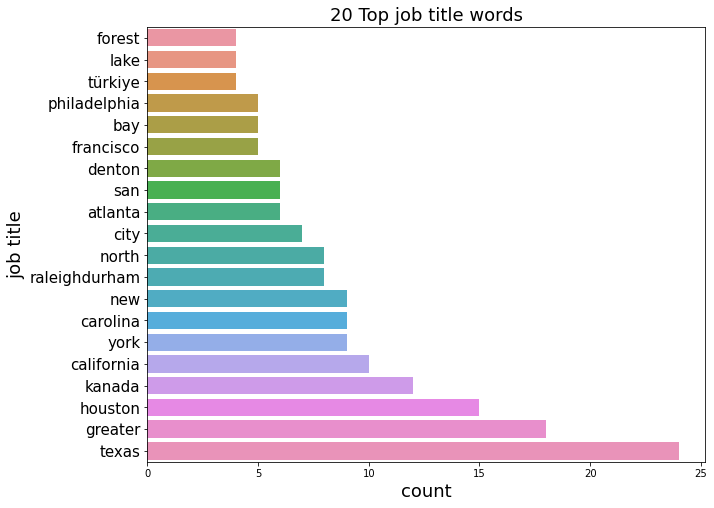

In [284]:
# dict(genres_counts) convert to dictionary
dfg = df_location.tail(20)
plt.figure(figsize = (10,8))
sns.barplot(data = dfg, y= dfg.index, x='count_location')
plt.title('20 Top job title words', fontsize =18)
plt.xlabel('count', fontsize =18)
plt.ylabel('job title', fontsize =18)
plt.yticks(fontsize=15)
plt.show()

In [285]:
for x in count_location:
  if x == 'area':
    count_location.remove(x)

In [286]:
all_words_joined2 = ' '.join(count_location)
all_words_joined2

'houston texas kanada raleighdurham north carolina denton texas zmir türkiye greater new york city kanada san francisco bay kanada greater philadelphia lake forest california houston texas atlanta georgia houston texas houston texas kanada raleighdurham north carolina denton texas houston texas kanada raleighdurham north carolina denton texas zmir türkiye greater new york city kanada san francisco bay houston texas chicago illinois houston texas chicago illinois houston texas kanada raleighdurham north carolina denton texas zmir türkiye greater new york city kanada san francisco bay kanada greater philadelphia lake forest california houston texas atlanta georgia houston texas kanada raleighdurham north carolina denton texas zmir türkiye greater new york city kanada san francisco bay kanada greater philadelphia lake forest california houston texas atlanta georgia houston texas raleighdurham north carolina denton texas greater new york city san francisco bay greater philadelphia lake for

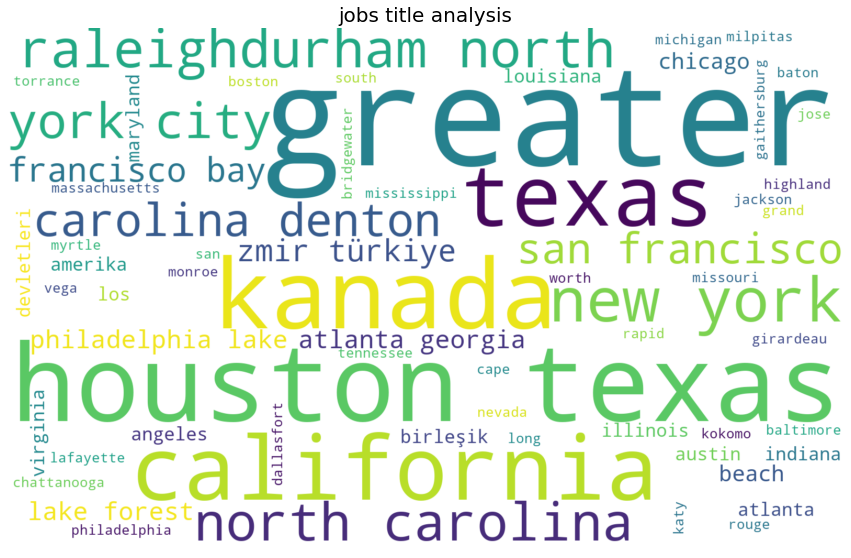

In [287]:
# plot the WordCloud image
generate_show_wordcloud(all_words_joined2)

# Modeling

## 1. TF-IDF

In [288]:
def join_clean_text_lem(text):
    text = "".join([word.lower() for word in text if word not in string.punctuation])
    tokens = re.split('\W+', text)
    tokens = [t for t in tokens if t.isalpha()] # remove numeric 
    tokens = [word for word in tokens if not any(c.isdigit() for c in word)]                      
    text = [wn.lemmatize(word) for word in tokens if word not in stopword] # stemming and remove stopword 
    # remove empty tokens and tokens of 1 letter 
    text = [t for t in text if len(t) > 2]  # 3
    # join all
    text = " ".join(text)
    return text

In [289]:
df['join_job_clean_lem'] = df['job_title'].apply(lambda row: join_clean_text_lem(row))
df['join_location_clean_lem'] = df['location'].apply(lambda row: join_clean_text_lem(row))

In [290]:
df['join_job_clean_lem'].head()

0    bauer college business graduate magna cum laud...
1    native english teacher epik english program korea
2                 aspiring human resource professional
3                  people development coordinator ryan
4         advisory board member celal bayar university
Name: join_job_clean_lem, dtype: object

In [291]:
# Prep our Text for Modelling
vectorizer_job = TfidfVectorizer(stop_words='english', ngram_range = (1, 2))
job_tfidf = vectorizer_job.fit_transform(df['join_job_clean_lem'])
job_tfidf.shape

(104, 351)

In [292]:
job_tfidf

<104x351 sparse matrix of type '<class 'numpy.float64'>'
	with 1129 stored elements in Compressed Sparse Row format>

In [293]:
#f = pd.DataFrame(tfidf_matrix.toarray(), columns= tfidf_vectorizer.get_feature_names())
vec_job_df = pd.DataFrame(job_tfidf.toarray(), columns= vectorizer_job.get_feature_names())
vec_job_df.tail()

,administration,administration excellence,administrative,administrative professional,admission,admission representative,advisory,advisory board,america,america groupe,analyst,analytics,analytics traveler,army,army national,art,art major,aspiring,aspiring human,assistant,assistant styczynski,atlanta,bachelor,bachelor science,bauer,bauer college,bayar,bayar university,beach,beneteau,biology,biology victoria,board,board member,brand,brand portfolio,buckhead,buckhead atlanta,business,business graduate,business intelligence,business management,business partner,care,celal,celal bayar,center,center long,chapman,chapman university,chro,chro marketing,college,college aspiring,college business,communication,communication csr,community,community medical,compensation,conflict,conflict management,coordinator,coordinator intercontinental,coordinator ryan,create,create inclusive,csr,csr officer,cum,cum laude,customer,customer service,data,data organization,delphi,delphi hardware,development,development coordinator,director,director administration,director human,employment,employment opportunity,endemol,endemol shine,energetic,energetic teamfocused,energy,energy gphr,engaging,engaging work,engie,engie houston,engineer,engineer information,english,english program,english teacher,entrylevel,entrylevel human,environment,environmental,epik,epik english,excellence,excellence logging,executive,executive jti,experienced,experienced retail,generalist,generalist loparex,generalist position,generalist schwans,generalist scottmadden,gphr,gphr sphr,graduate,graduate magna,graduating,graduating seeking,groupe,groupe beneteau,guard,guard recruiter,hardware,hardware paint,heil,heil environmental,helping,helping create,houston,houston woodland,hris,hris generalist,human,human resource,humber,humber college,illinois,illinois university,inclusive,inclusive engaging,indiana,indiana university,information,information specialist,intelligence,intelligence analytics,intercontinental,intercontinental buckhead,international,internship,internship human,japan,japan tobacco,jti,jti japan,junior,junior engineer,kokomo,kokomo business,korea,lab,laude,laude aspiring,lead,lead official,leader,leader software,liberal,liberal art,logging,long,long beach,loparex,louis,love,love data,luxottica,magna,magna cum,major,major aspiring,management,management major,management policy,management retail,management student,managementbenefits,managementbenefits compensation,manager,manager aspiring,manager delphi,manager endemol,manager graduating,manager seeking,marketing,marketing communication,medical,medical center,member,member celal,national,national guard,native,native english,north,north america,nortia,nortia staffing,office,office manager,officer,officer engie,official,official western,open,open travel,opportunity,opportunity customer,opportunity open,organization,paint,partner,partner heil,passionate,passionate helping,patient,patient care,payroll,payroll administrative,people,people development,policy,policy procedurestalent,portfolio,portfolio executive,position,position human,position louis,procedurestalent,procedurestalent managementbenefits,professional,professional energetic,professional passionate,professional world,program,program korea,programmer,programmer love,recruiter,recruiter office,recruiting,recruiting professional,relocation,representative,representative community,research,research assistant,resource,resource analyst,resource business,resource conflict,resource coordinator,resource generalist,resource hris,resource management,resource manager,resource north,resource opportunity,resource payroll,resource position,resource professional,resource specialist,resource staffing,retail,retail manager,retired,retired army,rrp,rrp brand,ryan,schwans,science,science biology,scottmadden,seeking,seeking employment,seeking entrylevel,seeking human,seeking internship,seeking position,senior,senior human,senior specialist,service,service patient,set,set success,shine,shine north

In [294]:
def get_tf_idf_similarity(cleaning_text,  clean_query):
    """
    vectorizer: TfIdfVectorizer model
    docs_tfidf: tfidf vectors for all docs
    query: query doc

    return: cosine similarity between query and all docs
    """
    # Prep our Text for Modelling
    vectorizer_text = TfidfVectorizer(stop_words='english', ngram_range = (1, 2))
    job_tfidf = vectorizer_text.fit_transform(cleaning_text)

    query_tfidf = vectorizer_text.transform([clean_query])
    cos_sim = cosine_similarity(query_tfidf, job_tfidf).flatten()
    
    return cos_sim

In [295]:
query = 'aspiring human ressources'
fit_cos_sim = get_tf_idf_similarity(df['join_job_clean_lem'],query)
df['fit_tfidf'] = fit_cos_sim

In [296]:
df[['fit_tfidf', 'connection']].sort_values(by= 'fit_tfidf', ascending = False).head(20)

,fit_tfidf,connection
45,0.611085,44
16,0.611085,44
2,0.611085,44
57,0.611085,44
32,0.611085,44
20,0.611085,44
96,0.611085,71
59,0.529739,1
35,0.529739,1
48,0.529739,1


In [297]:
df[['fit_tfidf', 'connection']].corr()

,fit_tfidf,connection
fit_tfidf,1.0000,-0.5429
connection,-0.5429,1.0000


In [298]:
df[['job_title', 'fit_tfidf', 'connection',  'location_clean_lem']].sort_values(by= 'fit_tfidf', ascending = False).head(20)

,job_title,fit_tfidf,connection,location_clean_lem
45,Aspiring Human Resources Professional,0.611085,44,"[raleighdurham, north, carolina, area]"
16,Aspiring Human Resources Professional,0.611085,44,"[raleighdurham, north, carolina, area]"
2,Aspiring Human Resources Professional,0.611085,44,"[raleighdurham, north, carolina, area]"
57,Aspiring Human Resources Professional,0.611085,44,"[raleighdurham, north, carolina, area]"
32,Aspiring Human Resources Professional,0.611085,44,"[raleighdurham, north, carolina, area]"
20,Aspiring Human Resources Professional,0.611085,44,"[raleighdurham, north, carolina, area]"
96,Aspiring Human Resources Professional,0.611085,71,"[kokomo, indiana, area]"
59,Aspiring Human Resources Specialist,0.529739,1,"[greater, new, york, city, area]"
35,Aspiring Human Resources Specialist,0.529739,1,"[greater, new, york, city, area]"
48,Aspiring Human Resources Specialist,0.529739,1,"[greater, new, york, city, area]"


## 2. TF_IDF   II

In [299]:
# instantiate the tfidf vectorizer for trigrams
job_tfidf_trigrams = TfidfVectorizer(stop_words='english', ngram_range = (3,3)) # vectorizer
# Generate matrix of word vectors
job_tfidf_trigrams_mat = job_tfidf_trigrams.fit_transform(df['join_job_clean_lem'])

# Print the shape of tfidf_matrix
print(job_tfidf_trigrams_mat.shape)

(104, 173)


In [300]:
job_tfidf_trigrams.get_feature_names()[:5]

['administration excellence logging',
 'admission representative community',
 'advisory board member',
 'america groupe beneteau',
 'army national guard']

In [301]:
query_1 = 'Aspiring human resources'
query_2 = 'seeking human resources'
# preprocessing of key words
query_1_clean = join_clean_text_lem(query_1)
query_2_clean = join_clean_text_lem(query_2)
print(query_1_clean)
print(query_2_clean)

aspiring human resource
seeking human resource


In [302]:
def get_tf_idf_similarity_2(cleaning_text, query):
    """
    vectorizer: TfIdfVectorizer model
    docs_tfidf: tfidf vectors for all docs
    query: query doc

    return: cosine similarity between query and all docs
    """
    # Prep our Text for Modelling
    vectorizer_text = TfidfVectorizer(stop_words='english', ngram_range = (3, 3))
    job_tfidf = vectorizer_text.fit_transform(cleaning_text)

    query_tfidf = vectorizer_text.transform([query])
    cos_sim = cosine_similarity(query_tfidf, job_tfidf).flatten()
    
    return cos_sim

In [303]:
fit_cos_sim2 = get_tf_idf_similarity_2(df['join_job_clean_lem'], query_1_clean)
df['fit_tfidf2'] = fit_cos_sim2

In [304]:
df[['job_title', 'fit_tfidf', 'fit_tfidf2', 'connection',  'location_clean_lem']].sort_values(by= 'fit_tfidf', ascending = False).head(20)

,job_title,fit_tfidf,fit_tfidf2,connection,location_clean_lem
45,Aspiring Human Resources Professional,0.611085,0.614482,44,"[raleighdurham, north, carolina, area]"
16,Aspiring Human Resources Professional,0.611085,0.614482,44,"[raleighdurham, north, carolina, area]"
2,Aspiring Human Resources Professional,0.611085,0.614482,44,"[raleighdurham, north, carolina, area]"
57,Aspiring Human Resources Professional,0.611085,0.614482,44,"[raleighdurham, north, carolina, area]"
32,Aspiring Human Resources Professional,0.611085,0.614482,44,"[raleighdurham, north, carolina, area]"
20,Aspiring Human Resources Professional,0.611085,0.614482,44,"[raleighdurham, north, carolina, area]"
96,Aspiring Human Resources Professional,0.611085,0.614482,71,"[kokomo, indiana, area]"
59,Aspiring Human Resources Specialist,0.529739,0.487516,1,"[greater, new, york, city, area]"
35,Aspiring Human Resources Specialist,0.529739,0.487516,1,"[greater, new, york, city, area]"
48,Aspiring Human Resources Specialist,0.529739,0.487516,1,"[greater, new, york, city, area]"


## TD_IDF III

In [305]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

In [306]:
df['input'] = "aspiring human ressources" 

In [307]:
sim_tfidf = []
for i in range(len(df['join_job_clean_lem'])):
    score = cosine_sim(df['join_job_clean_lem'][i], df['input'][i])
    sim_tfidf.append(score)
print(sim_tfidf)

[0.22555487220684337, 0.0, 0.4112070550676187, 0.0, 0.0, 0.4112070550676187, 0.2910691023819054, 0.0, 0.2910691023819054, 0.1362763414390864, 0.0, 0.0, 0.1362763414390864, 0.22555487220684337, 0.22555487220684337, 0.0, 0.4112070550676187, 0.0, 0.22555487220684337, 0.0, 0.4112070550676187, 0.0, 0.0, 0.4112070550676187, 0.2910691023819054, 0.0, 0.2910691023819054, 0.17077611319011649, 0.2910691023819054, 0.17077611319011649, 0.22555487220684337, 0.0, 0.4112070550676187, 0.0, 0.0, 0.4112070550676187, 0.2910691023819054, 0.0, 0.2910691023819054, 0.1362763414390864, 0.0, 0.0, 0.1362763414390864, 0.22555487220684337, 0.0, 0.4112070550676187, 0.0, 0.0, 0.4112070550676187, 0.2910691023819054, 0.0, 0.2910691023819054, 0.1362763414390864, 0.0, 0.0, 0.1362763414390864, 0.22555487220684337, 0.4112070550676187, 0.0, 0.4112070550676187, 0.0, 0.1362763414390864, 0.0, 0.0, 0.1362763414390864, 0.2910691023819054, 0.15064018498706508, 0.17077611319011649, 0.12536693798731732, 0.09865621511919304, 0.1506

In [308]:
df["sim_tfidf"] = sim_tfidf

In [309]:
df[['fit_tfidf', 'fit_tfidf2', 'sim_tfidf', 'connection',  'location_clean_lem']].sort_values(by= 'fit_tfidf', ascending = False).head(20)

,fit_tfidf,fit_tfidf2,sim_tfidf,connection,location_clean_lem
45,0.611085,0.614482,0.411207,44,"[raleighdurham, north, carolina, area]"
16,0.611085,0.614482,0.411207,44,"[raleighdurham, north, carolina, area]"
2,0.611085,0.614482,0.411207,44,"[raleighdurham, north, carolina, area]"
57,0.611085,0.614482,0.411207,44,"[raleighdurham, north, carolina, area]"
32,0.611085,0.614482,0.411207,44,"[raleighdurham, north, carolina, area]"
20,0.611085,0.614482,0.411207,44,"[raleighdurham, north, carolina, area]"
96,0.611085,0.614482,0.411207,71,"[kokomo, indiana, area]"
59,0.529739,0.487516,0.411207,1,"[greater, new, york, city, area]"
35,0.529739,0.487516,0.411207,1,"[greater, new, york, city, area]"
48,0.529739,0.487516,0.411207,1,"[greater, new, york, city, area]"


# Word Embedding - word2vec

In [312]:
tokens = df['job_clean_lem']
tokens[:5]

0    [bauer, college, business, graduate, magna, cu...
1    [native, english, teacher, epik, english, prog...
2            [aspiring, human, resource, professional]
3             [people, development, coordinator, ryan]
4    [advisory, board, member, celal, bayar, univer...
Name: job_clean_lem, dtype: object

In [313]:
#from gensim.models import Word2Vec
#tokens = df['join_job_clean_lem'].apply(lambda x: nltk.word_tokenize(x))
# # Train Word2Vec model. 
w2v_model = Word2Vec(tokens,
                     min_count=1,
                     window=10,
                     size = 250, # vector_size=250 for each words,
                     alpha=0.03, 
                     min_alpha=0.0007,
                     workers = 4,
                     seed = 42)

In [314]:
# Get the word vector for given word
w2v_model['human'][:10]

array([-0.00189373,  0.00088736,  0.0016369 ,  0.00078826,  0.00098078,
       -0.00177095, -0.00053233, -0.0009331 , -0.00102037,  0.00044078],
      dtype=float32)

In [315]:
len(w2v_model['human']) # the 250 dimentional vector of the word human

250

In [316]:
w2v_model.most_similar('human')

[('member', 0.1910954713821411),
 ('coordinator', 0.1668403148651123),
 ('groupe', 0.15313494205474854),
 ('teacher', 0.1492968499660492),
 ('university', 0.14706405997276306),
 ('recruiter', 0.14637555181980133),
 ('may', 0.14418919384479523),
 ('engie', 0.13129109144210815),
 ('assistant', 0.1303943544626236),
 ('delphi', 0.12381622940301895)]

In [317]:
# Save and Load Model
w2v_model.save('gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/word2vec_model')
w2v_model = Word2Vec.load('gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/word2vec_model')

In [318]:
#How many words does our model have?
len(w2v_model.wv.vocab)

170

In [319]:
# Is the word 'women' in our vocabulary?
'women' in w2v_model.wv.vocab

False

In [320]:
# Getting the list of all words in our vocabulary is easy. We can even sort them with the Python sorted function. 
wordss = sorted(w2v_model.wv.vocab.keys())
wordss[:10]

['administration',
 'administrative',
 'admission',
 'advisory',
 'always',
 'america',
 'analyst',
 'analytics',
 'army',
 'art']

In [321]:
# Update the model with new data.
#m2v_model.build_vocab(data_part2, update=True)
#m2v_model.train(data_part2, total_examples=model.corpus_count, epochs=model.iter)
#m2v_model['human']

In [322]:
#https://samyzaf.com/ML/nlp/nlp.html
# Save words to file: words.txt

#fp = open("words.txt", "w", encoding="utf-8")
#for word in wordss:
#    fp.write(word + '\n')
#fp.close()

def get_unmatching_word(words):
    for word in words:
        if not word in model.wv.vocab:
            print("Word is not in vocabulary:", word)
            return None
    return model.wv.doesnt_match(words)

#get_unmatching_word(['breakfast', 'cereal', 'dinner', 'lunch'])

In [323]:
dir(w2v_model)

['__class__',
 '__contains__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__ignoreds',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__numpys',
 '__recursive_saveloads',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__scipys',
 '__setattr__',
 '__sizeof__',
 '__slotnames__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_check_input_data_sanity',
 '_check_training_sanity',
 '_clear_post_train',
 '_do_train_epoch',
 '_do_train_job',
 '_get_job_params',
 '_get_thread_working_mem',
 '_job_producer',
 '_load_specials',
 '_log_epoch_end',
 '_log_epoch_progress',
 '_log_progress',
 '_log_train_end',
 '_minimize_model',
 '_raw_word_count',
 '_save_specials',
 '_set_train_params',
 '_smart_save',
 '_train_epoch',
 '_train_epoch_corpusfile',
 '_update_job_params',
 '_worker_loop',
 '_worker_loop_corpusfile',


In [324]:
from sklearn.decomposition import PCA
from matplotlib import pyplot

Text(-0.0012925772, 0.00016121106, 'bauer')

Text(-0.0023953996, -0.0015196769, 'college')

Text(0.0002915387, 0.0021061979, 'business')

Text(-0.0015287112, -0.0012724926, 'graduate')

Text(0.005743169, 0.0012091813, 'magna')

Text(-7.658296e-05, -0.0012430896, 'cum')

Text(-0.003373915, 0.00041947333, 'laude')

Text(-0.0018428075, 0.0023475224, 'aspiring')

Text(-0.0029790595, 0.008759606, 'human')

Text(-0.0008701587, 0.001735732, 'resource')

Text(-0.0044370713, -0.00064123684, 'professional')

Text(4.3382162e-05, -0.00081688794, 'native')

Text(-0.0012461417, 0.0018215245, 'english')

Text(-0.00037633962, 0.005199507, 'teacher')

Text(0.004258579, -0.0006565234, 'epik')

Text(-0.001630007, -0.0017027529, 'program')

Text(0.0004547539, -0.0033723516, 'korea')

Text(0.00018762276, -0.0042080064, 'people')

Text(0.0020308618, 0.00050294766, 'development')

Text(-0.0035358889, 0.0031138458, 'coordinator')

Text(-0.0042689764, 0.0010671624, 'ryan')

Text(-0.004222644, -0.0005087222, 'advisory')

Text(0.004925806, -0.0022453223, 'board')

Text(-0.0022500893, 0.0044568875, 'member')

Text(5.3368123e-05, 0.002070038, 'celal')

Text(0.0017468127, 0.001142139, 'bayar')

Text(-0.0026482223, 0.004685928, 'university')

Text(0.00026733658, 0.0023609577, 'specialist')

Text(0.0014081529, 0.00036659758, 'student')

Text(0.00093941, 0.00041594962, 'humber')

Text(-0.0003215568, 0.0024668674, 'generalist')

Text(-0.0012475125, -2.1669839e-05, 'senior')

Text(-0.00013715154, 0.00012347056, 'seeking')

Text(-0.0022902032, -0.0007215446, 'hris')

Text(0.0004994061, 0.0018228758, 'position')

Text(0.0026803962, -0.00026322572, 'chapman')

Text(-0.0015853489, 0.0020951522, 'svp')

Text(-0.0020133513, -0.0023168006, 'chro')

Text(0.000445556, -0.0027735764, 'marketing')

Text(-9.920799e-07, -0.0027581735, 'communication')

Text(0.0010099683, 0.002954204, 'csr')

Text(-0.0008154598, 0.00086442166, 'officer')

Text(-0.003315904, 0.00077541993, 'engie')

Text(-0.00487878, -0.003408829, 'houston')

Text(-0.00015929517, 0.0021758985, 'woodland')

Text(-0.0027735566, 0.003283844, 'energy')

Text(-0.0008571354, 0.00022769728, 'gphr')

Text(0.0006859001, 0.0016545806, 'sphr')

Text(-0.003556706, -0.0029595476, 'intercontinental')

Text(-0.002347762, 0.00014584794, 'buckhead')

Text(-0.00048904074, -0.00126164, 'atlanta')

Text(-0.0019868407, -5.8681595e-05, 'management')

Text(-0.0015661328, 0.000101727914, 'internship')

Text(-0.0038539644, -0.0030119636, 'opportunity')

Text(0.0038492852, -0.0006586288, 'experienced')

Text(0.00241635, -0.0025617664, 'retail')

Text(-0.0019017344, -0.0034428407, 'manager')

Text(0.0014179721, 0.0005625212, 'staffing')

Text(0.007979805, -0.0011515209, 'recruiting')

Text(0.003624812, 0.00049177394, 'luxottica')

Text(0.0014179895, -0.0028449772, 'director')

Text(0.001121103, 0.0011799638, 'north')

Text(-0.0016412175, 0.0043112966, 'america')

Text(0.0052438886, 0.004574114, 'groupe')

Text(-0.00045902957, 0.0017477147, 'beneteau')

Text(0.00055097026, -0.0011745403, 'retired')

Text(0.00025242177, 0.0047224183, 'army')

Text(0.000852921, 0.0006221871, 'national')

Text(0.0025909226, -0.0035815327, 'guard')

Text(0.0015231665, 0.0027072276, 'recruiter')

Text(0.00036390751, 0.0015703993, 'office')

Text(-0.0019930024, 0.0012529421, 'scottmadden')

Text(0.003956412, 0.0013084819, 'inc')

Text(0.0030628983, -0.0019769857, 'major')

Text(-0.0002261514, 0.0006694692, 'nortia')

Text(0.0014211119, 0.0012438176, 'payroll')

Text(-0.0006989447, -0.00072925957, 'administrative')

Text(0.001427005, -0.002469256, 'passionate')

Text(0.0016879314, -0.0001993609, 'helping')

Text(-0.002815981, 0.003441702, 'create')

Text(-0.0005487819, -0.0035819449, 'inclusive')

Text(0.0021502827, 0.0001885105, 'engaging')

Text(-0.00061893073, -0.002129653, 'work')

Text(-0.0010690762, -0.0041325344, 'environment')

Text(-0.0006930418, 0.0014415968, 'conflict')

Text(0.0014210826, -0.00048591942, 'policy')

Text(-0.0035139464, -0.006412499, 'procedurestalent')

Text(-0.0026914603, 0.0024735795, 'managementbenefits')

Text(0.0063223313, -0.0011097569, 'compensation')

Text(0.0065344786, -9.5442265e-05, 'schwans')

Text(0.00303679, 0.0049245586, 'liberal')

Text(-0.005203414, -0.0023915656, 'art')

Text(-0.00341671, -0.0005565197, 'analyst')

Text(-0.0029558179, -0.0028403897, 'junior')

Text(-0.0008530903, 0.0022370948, 'engineer')

Text(0.0048100175, -0.0025748299, 'information')

Text(-0.0017247916, -0.0018027155, 'system')

Text(0.0021357494, 0.0025436124, 'partner')

Text(0.003295251, -0.0019060804, 'heil')

Text(-0.0029921813, 0.0006024821, 'environmental')

Text(0.00040627187, 0.0037765503, 'energetic')

Text(-0.002115127, 0.0011199634, 'teamfocused')

Text(-0.0037916237, -0.0005073431, 'leader')

Text(0.00078394084, 0.0024674388, 'endemol')

Text(0.002574415, -0.0019849807, 'shine')

Text(-0.0018171818, 0.0010317664, 'world')

Text(0.0010292433, 0.0015471564, 'software')

Text(-0.001625684, -0.00081564806, 'rrp')

Text(-0.0038792263, -0.0011824477, 'brand')

Text(0.0007414454, 0.0015810865, 'portfolio')

Text(-0.0021429101, -0.0057099797, 'executive')

Text(0.0035439725, 0.0005127728, 'jti')

Text(0.0015407864, 0.0022338186, 'japan')

Text(0.0010754382, -0.0038023752, 'tobacco')

Text(0.0015207387, -0.0038054455, 'international')

Text(0.00043499703, -0.0020781413, 'programmer')

Text(-0.0006970054, -0.005467706, 'love')

Text(-0.0030971272, 0.0022219701, 'data')

Text(0.0024952423, -0.003064854, 'organization')

Text(0.00030469932, -0.0026169776, 'bachelor')

Text(0.00048970943, 0.00047839465, 'science')

Text(-0.0022372333, 0.0033830272, 'biology')

Text(-0.0030586533, -0.00410133, 'victoria')

Text(0.0043325843, 0.002118795, 'wellington')

Text(-0.002029335, -0.0016194683, 'undergraduate')

Text(-0.0026476956, -0.0019376961, 'research')

Text(-0.00019836657, 0.00095253444, 'assistant')

Text(-0.00066404964, 0.0013366896, 'styczynski')

Text(-0.0005829541, -0.003144558, 'lab')

Text(-5.1587806e-05, -0.0010580224, 'lead')

Text(-0.0004958581, 0.0017282822, 'official')

Text(0.0013447066, -0.0049847974, 'western')

Text(0.0021053844, 0.0018643237, 'illinois')

Text(-0.0009600263, -0.0021146964, 'employment')

Text(-0.004244227, 0.0011314492, 'within')

Text(0.002222058, -0.0025743793, 'customer')

Text(-0.0013224981, 0.00132994, 'service')

Text(0.006541142, 0.00045322697, 'patient')

Text(0.0018303636, -0.004166725, 'care')

Text(0.0021414636, -0.001271771, 'admission')

Text(0.001639956, 0.0021277405, 'representative')

Text(-0.002424877, -0.0015914902, 'community')

Text(0.0022733845, 0.0004496399, 'medical')

Text(-0.00031214388, 0.0016144353, 'center')

Text(-0.0019393268, -0.00016753821, 'long')

Text(-0.001484663, 0.0014034025, 'beach')

Text(-0.0038712667, -0.0027886762, 'open')

Text(-0.00034681344, 0.001714165, 'travel')

Text(-0.0023072707, 0.0023917754, 'relocation')

Text(0.0069635618, -0.00014423562, 'westfield')

Text(-0.00021000393, -0.0025944293, 'state')

Text(0.0014731535, 0.0048003118, 'indiana')

Text(-0.00380573, -0.0008769161, 'kokomo')

Text(-9.4312614e-05, 0.0015483132, 'delphi')

Text(-0.003935443, 0.0007104712, 'hardware')

Text(0.0025898905, -0.0008251434, 'paint')

Text(0.0010779229, -0.0048531108, 'graduating')

Text(-0.00058001047, 0.0052466113, 'may')

Text(-0.0006993944, -0.0011893056, 'entrylevel')

Text(0.0007611792, 0.00021301636, 'louis')

Text(-0.00012629427, 0.00029175385, 'loparex')

Text(0.0013863223, 0.002288535, 'intelligence')

Text(0.0020292713, -0.0005934628, 'analytics')

Text(0.0007601368, 0.0014082146, 'traveler')

Text(-0.0015209065, -0.0028423183, 'always')

Text(0.0024385888, -0.0042124134, 'set')

Text(0.0019321352, 0.0019515756, 'success')

Text(0.00038755333, 0.002857339, 'administration')

Text(0.0012606845, 0.00017927644, 'excellence')

Text(0.0039342274, -0.0006760487, 'logging')

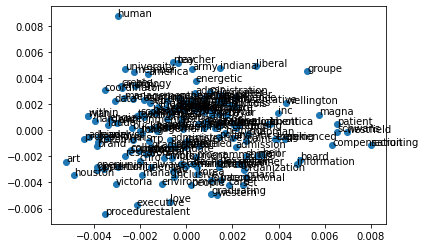

In [325]:
# fit a 2d PCA model to the vectors
X = w2v_model[w2v_model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = list(w2v_model.wv.vocab) #words = list(FastText.wv.index_to_key)

for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [326]:
w2v_model.wv.vocab

{'bauer': <gensim.models.keyedvectors.Vocab at 0x7fa614807bb0>,
 'college': <gensim.models.keyedvectors.Vocab at 0x7fa614807df0>,
 'business': <gensim.models.keyedvectors.Vocab at 0x7fa6148072b0>,
 'graduate': <gensim.models.keyedvectors.Vocab at 0x7fa614807d60>,
 'magna': <gensim.models.keyedvectors.Vocab at 0x7fa614807d30>,
 'cum': <gensim.models.keyedvectors.Vocab at 0x7fa614807a00>,
 'laude': <gensim.models.keyedvectors.Vocab at 0x7fa614807b50>,
 'aspiring': <gensim.models.keyedvectors.Vocab at 0x7fa614807a60>,
 'human': <gensim.models.keyedvectors.Vocab at 0x7fa614807b80>,
 'resource': <gensim.models.keyedvectors.Vocab at 0x7fa614807e50>,
 'professional': <gensim.models.keyedvectors.Vocab at 0x7fa6148074f0>,
 'native': <gensim.models.keyedvectors.Vocab at 0x7fa614807cd0>,
 'english': <gensim.models.keyedvectors.Vocab at 0x7fa6148078b0>,
 'teacher': <gensim.models.keyedvectors.Vocab at 0x7fa614807400>,
 'epik': <gensim.models.keyedvectors.Vocab at 0x7fa614807c10>,
 'program': <gens

In [327]:
w2v_model[w2v_model.wv.vocab]

array([[ 1.6370764e-03,  4.9649167e-04, -8.6510525e-04, ...,
         1.1482075e-03,  1.3125667e-03,  7.2312902e-04],
       [-1.4342659e-03, -1.9036278e-03,  1.8986857e-03, ...,
        -4.1570741e-04,  1.6722910e-04, -1.1297091e-03],
       [ 4.5767723e-04, -1.5094619e-03,  4.5895911e-04, ...,
         2.5439079e-04,  1.9400449e-03, -1.5801068e-03],
       ...,
       [-1.9529680e-03,  1.7777567e-03,  6.1557692e-04, ...,
        -3.3193707e-04, -1.5822648e-03, -5.1566603e-04],
       [-5.9961638e-04,  1.2812235e-03,  1.3313212e-03, ...,
        -1.6458754e-03,  1.1426053e-03,  1.6198840e-03],
       [-8.8074472e-04,  2.3448901e-04,  1.9405695e-04, ...,
        -7.3241667e-05,  3.6544542e-04,  1.6091068e-03]], dtype=float32)

In [328]:
indextokey_set = set(w2v_model.wv.vocab) # got from the train model, get only    unique word 
def avg_feature_vector(sentence, w2v_model, num_features, index2word_set): 
  """ sentence : each row of the df[text] 
      model: trainned model 
      num_features : from trained model , it was set at 250
      set(w2v_model.wv.vocab) # got from the train model
  """
  words = sentence.split() # one row of the dataframe text
  feature_vec = np.zeros((num_features, ), dtype='float32') # initialize an empty 
  n_words = 0 # initialize the count at zero
  for word in words: # for word in each row of the df[text] 
    if word in index2word_set: # if the word of the df[text] in  model.wv.vocal 
      n_words += 1 # count the word / increment by one
      feature_vec = np.add(feature_vec, w2v_model.wv[word]) # add the word 
                
    if (n_words > 0):
                feature_vec = np.divide(feature_vec, n_words) # divide to get average
    return feature_vec  

In [329]:
len(w2v_model.wv.vocab)

170

In [330]:
score1 = []
for sentence in df['join_job_clean_lem']:
    s1_afv = avg_feature_vector(sentence, w2v_model, num_features=250, index2word_set=indextokey_set)     
    score1.append(s1_afv)

In [331]:
len(score1)

104

In [332]:
score1[:1]

[array([ 1.6370764e-03,  4.9649167e-04, -8.6510525e-04, -8.3456648e-04,
        -6.9989765e-04,  3.6375612e-04,  5.1342807e-04, -1.3061152e-03,
         1.0498199e-03, -1.5714237e-03,  5.0753914e-04, -1.5317276e-03,
        -1.6406162e-03,  1.6387473e-03,  1.0383048e-04,  5.2148156e-04,
         2.2412995e-04,  1.9350543e-03, -9.2507125e-04, -4.1770606e-04,
        -1.6592956e-03, -1.5894666e-03, -1.4380239e-03, -1.1567207e-03,
         1.3382622e-03, -3.1051468e-04, -3.4312709e-04,  9.7691582e-04,
         1.3571999e-03,  1.3136120e-03, -1.4744304e-03, -9.3742402e-04,
         6.3612667e-04, -1.3306109e-03, -1.1872805e-03, -6.2815036e-04,
        -3.4241134e-04, -6.1815296e-04,  1.6900486e-03,  1.2426114e-03,
         1.3653082e-03, -7.9187780e-04,  7.0347247e-04, -2.7753474e-04,
         1.9235923e-03, -1.5359522e-03,  3.0213236e-05, -1.6325234e-03,
        -9.9792320e-04,  1.5885629e-03,  7.0636095e-05,  1.7585530e-03,
        -8.5845432e-04,  1.5880069e-03, -9.7205385e-04,  1.95376

In [333]:
len(score1[:1])

1

In [334]:
s1_afv[:1]

array([0.00093316], dtype=float32)

In [335]:
query_1_clean

'aspiring human resource'

In [336]:
df['input'] = query_1_clean

In [337]:
score2 = []
for sentence in df['input']:
    s2_afv = [avg_feature_vector(sentence, w2v_model, num_features=250, index2word_set=indextokey_set)]
    score2.append(s2_afv)

In [338]:
s2_afv[:1]

[array([ 1.1435178e-03,  1.5715216e-03,  1.6183262e-03, -1.6789983e-03,
        -9.5857156e-04, -1.4983867e-03, -5.7302939e-04, -1.9514721e-03,
         1.3332565e-03, -3.4635206e-04, -1.5926668e-03, -1.1875571e-03,
         1.9905730e-03, -1.9688618e-03, -9.2081353e-04,  3.2898149e-04,
         1.4404500e-03, -1.4244218e-03,  1.5191599e-03,  1.4795114e-04,
        -1.9146472e-03,  1.3834018e-03,  8.4397808e-04,  9.2984113e-04,
        -6.3019490e-04,  1.9678471e-03,  5.8049028e-04,  1.2649505e-03,
        -4.4577813e-05, -4.5657219e-04,  1.3177535e-03, -1.5130016e-03,
         1.3676699e-03, -5.3965684e-04,  5.0404499e-04,  1.4630840e-03,
         1.0657040e-03, -9.3711627e-04, -1.5144370e-03,  1.1636899e-03,
         1.9382056e-03,  5.4303871e-04,  2.0498782e-03, -1.8198553e-03,
         1.5082931e-03,  6.1464630e-04,  7.3093496e-04,  4.4988096e-04,
         1.2825476e-04, -1.3857397e-03,  1.1829351e-03,  1.7018864e-03,
         1.1776955e-03,  1.2608395e-03,  9.5420796e-04, -5.67137

In [339]:
sim_word2vec = []
for i in range(len(score1)):
    sim = 1 - spatial.distance.cosine(score1[i],score2[i])
    sim_word2vec.append(sim)
print(sim_word2vec)

[0.0223944541066885, 0.03516937792301178, 1, 0.13409671187400818, -0.0513153038918972, 1, -0.027367012575268745, -0.033967044204473495, -0.027367012575268745, 0.13301990926265717, -0.027367012575268745, -0.02407720498740673, 0.058703821152448654, 0.0223944541066885, 0.0223944541066885, 0.03516937792301178, 1, 0.13409671187400818, 0.0223944541066885, 0.03516937792301178, 1, 0.13409671187400818, -0.0513153038918972, 1, -0.027367012575268745, -0.033967044204473495, 1, 0.13301990926265717, 1, 0.13301990926265717, 0.0223944541066885, 0.03516937792301178, 1, 0.13409671187400818, -0.0513153038918972, 1, -0.027367012575268745, -0.033967044204473495, -0.027367012575268745, 0.13301990926265717, -0.027367012575268745, -0.02407720498740673, 0.058703821152448654, 0.0223944541066885, 0.03516937792301178, 1, 0.13409671187400818, -0.0513153038918972, 1, -0.027367012575268745, -0.033967044204473495, -0.027367012575268745, 0.13301990926265717, -0.027367012575268745, -0.02407720498740673, 0.0587038211524

In [340]:
df["model_word2vec"] = sim_word2vec

In [341]:
df[['job_title', 'fit_tfidf', 'fit_tfidf2', 'sim_tfidf', 'model_word2vec','connection',  'location_clean_lem']].sort_values(by= 'fit_tfidf', ascending = False).head(20)

,job_title,fit_tfidf,fit_tfidf2,sim_tfidf,model_word2vec,connection,location_clean_lem
45,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,44,"[raleighdurham, north, carolina, area]"
16,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,44,"[raleighdurham, north, carolina, area]"
2,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,44,"[raleighdurham, north, carolina, area]"
57,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,44,"[raleighdurham, north, carolina, area]"
32,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,44,"[raleighdurham, north, carolina, area]"
20,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,44,"[raleighdurham, north, carolina, area]"
96,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,71,"[kokomo, indiana, area]"
59,Aspiring Human Resources Specialist,0.529739,0.487516,0.411207,1.000000,1,"[greater, new, york, city, area]"
35,Aspiring Human Resources Specialist,0.529739,0.487516,0.411207,1.000000,1,"[greater, new, york, city, area]"
48,Aspiring Human Resources Specialist,0.529739,0.487516,0.411207,1.000000,1,"[greater, new, york, city, area]"


# How to extract word vectors using pre-trained Word2Vec and FastText models?

In [342]:
# Download the models
#fasttext_model300 = api.load('fasttext-wiki-news-subwords-300')
#word2vec_model300 = api.load('word2vec-google-news-300')
#glove_model300 = api.load('glove-wiki-gigaword-300')

In [343]:
#word2vec_model300.most_similar('support')

In [344]:
# Save and Load Model
#fasttext_model300.save('gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/fasttext_model300')
#model = fasttext_model300.load('gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/fasttext_model300')

In [345]:
# Save and Load Model
#word2vec_model300.save('gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/word2vec_model300')
#word2vec_model300.load('gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/word2vec_model300')

In [346]:
# Save and Load Model
#glove_model300.save('gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/glove_model300')
#glove_model300.load('gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/glove_model300')

In [347]:
#from gensim.models import KeyedVectors
# Google Drive link https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit   to load and save model in googleDrive
model = KeyedVectors.load_word2vec_format("gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/GoogleNews-vectors-negative300.bin.gz", binary=True)

In [348]:
model

In [349]:
# define a function for word embedding
# load word2vec model
#word2vec_model = api.load('word2vec-google-news-300')


# define a function for word embedding

def avg_word_embedding(sentence, model):
    words = sentence.split()
    word_embedding = []
    for word in words:
        if word in model:
            word_embedding.append(model[word])
        else:
            word_embedding.append(np.zeros(300)) # append zero vectors if the word is not present in the corpus
    #print(word_embedding)
    #print(type(word_embedding))
    #print(len(word_embedding))
    # print('word_embedding[0].shape:%s'% word_embedding[0].shape)
    word_embedding_avg = np.mean(word_embedding, axis=0)
    #return np.mean(word_embedding, axis=0)
    return word_embedding_avg

In [350]:
avg_query_embedding = avg_word_embedding(query_1_clean, model)
avg_query_embedding

array([-3.13924141e-02, -1.22070312e-02,  1.05041504e-01,  2.31119785e-02,
       -4.35384102e-02,  6.70572892e-02,  1.95556641e-01, -1.66829433e-02,
       -1.57353714e-01,  9.71679688e-02, -4.21549492e-02, -3.11686192e-02,
       -1.62760413e-03, -1.79443359e-02, -6.53279647e-02,  1.55517578e-01,
       -3.39355469e-02,  1.59342453e-01, -4.33756523e-02, -9.74934921e-02,
       -9.68424510e-03, -9.70052108e-02, -1.25488281e-01, -4.38232422e-02,
        2.35188808e-02,  2.14233398e-02, -1.09029137e-01,  1.62923172e-01,
        1.21907555e-01, -1.82820633e-01,  9.53776017e-02, -8.46354142e-02,
       -1.17919922e-01, -1.14908852e-01, -1.29964188e-01, -1.11490889e-02,
        1.67643223e-02,  5.39550781e-02,  2.51139313e-01, -2.27050781e-02,
       -9.07389354e-03,  1.44694015e-01,  1.42415360e-04,  9.53776017e-02,
       -1.05794273e-01, -3.12500000e-02, -1.67643234e-01,  2.20052078e-01,
        4.70377617e-02,  4.30908203e-02, -5.79427071e-02, -1.24023438e-01,
       -1.22355141e-01,  

In [351]:
len(avg_query_embedding)

300

In [352]:
print(avg_query_embedding.shape)

(300,)


In [353]:
# create job title word embeddings
job_w2v_embeddings = []
for row in df['join_job_clean_lem']:
    # apply the avg_word_embedding function to each row and append to job_title_embeddings list
    job_w2v_embeddings.append(avg_word_embedding( row, model))
len(job_w2v_embeddings) 

104

In [354]:
job_w2v_embeddings[1].shape  

(300,)

In [355]:
# define a function for cosine similarity
def cosine_similarity(vec_A, vec_B):
    cos_sim = np.dot(vec_A, vec_B)/(np.linalg.norm(vec_A)* np.linalg.norm(vec_B))
    return cos_sim

In [356]:
similarity_scores = []
for job_embedding in job_w2v_embeddings:
    similarity_scores.append(cosine_similarity(avg_query_embedding, job_embedding))
print(similarity_scores)

[0.6231421, 0.24021612727066344, 0.9503953, 0.25359383, 0.2065627324240728, 0.91226155, 0.8290683297977184, 0.19570045, 0.8290683297977184, 0.70548004, 0.24427381, 0.30028216878450453, 0.5780699279782069, 0.6231421, 0.6231421, 0.24021612727066344, 0.9503953, 0.25359383, 0.6231421, 0.24021612727066344, 0.9503953, 0.25359383, 0.2065627324240728, 0.91226155, 0.8290683297977184, 0.19570045, 0.78397316, 0.75676745, 0.78397316, 0.75676745, 0.6231421, 0.24021612727066344, 0.9503953, 0.25359383, 0.2065627324240728, 0.91226155, 0.8290683297977184, 0.19570045, 0.8290683297977184, 0.70548004, 0.24427381, 0.30028216878450453, 0.5780699279782069, 0.6231421, 0.24021612727066344, 0.9503953, 0.25359383, 0.2065627324240728, 0.91226155, 0.8290683297977184, 0.19570045, 0.8290683297977184, 0.70548004, 0.24427381, 0.30028216878450453, 0.5780699279782069, 0.6231421, 0.9503953, 0.25359383, 0.91226155, 0.19570045, 0.70548004, 0.24427381, 0.30028216878450453, 0.5780699279782069, 0.77950716, 0.7065737, 0.741440

In [357]:
df['google_word2vec'] = similarity_scores
df[['job_title', 'fit_tfidf', 'fit_tfidf2', 'sim_tfidf', 'model_word2vec','google_word2vec','connection',  'location_clean_lem']].sort_values(by= 'fit_tfidf', ascending = False).head(20)

,job_title,fit_tfidf,fit_tfidf2,sim_tfidf,model_word2vec,google_word2vec,connection,location_clean_lem
45,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,44,"[raleighdurham, north, carolina, area]"
16,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,44,"[raleighdurham, north, carolina, area]"
2,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,44,"[raleighdurham, north, carolina, area]"
57,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,44,"[raleighdurham, north, carolina, area]"
32,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,44,"[raleighdurham, north, carolina, area]"
20,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,44,"[raleighdurham, north, carolina, area]"
96,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,71,"[kokomo, indiana, area]"
59,Aspiring Human Resources Specialist,0.529739,0.487516,0.411207,1.000000,0.912262,1,"[greater, new, york, city, area]"
35,Aspiring Human Resources Specialist,0.529739,0.487516,0.411207,1.000000,0.912262,1,"[greater, new, york, city, area]"
48,Aspiring Human Resources Specialist,0.529739,0.487516,0.411207,1.000000,0.912262,1,"[greater, new, york, city, area]"


# GloVe (Global Vectors)

In GloVe, we measure the similarity of the hidden factors between words to predict their co-occurrence count.

GloVe embeddings have been used in more than 2100 papers, and counting! You can use these pre-trained embeddings whenever you need a way to quantify word co-occurrence (which also captures some aspects of word meaning.)

In [358]:
# scipy
#from scipy.spatial.distance import cosine
# gensim
#from gensim.test.utils import get_tmpfile
#from gensim.models import KeyedVectors, Word2Vec   
#from gensim.scripts.glove2word2vec import glove2word2vec

In [359]:
# load glove model
#glove_model = api.load('glove-wiki-gigaword-300')

In [360]:
# load glove.6B.50d.txt and save in the directory
#https://nlp.stanford.edu/projects/glove/

In [361]:
# Create temp file and save converted embedding into it
target_file = get_tmpfile('glove.6B.50d.txt')
glove2word2vec('gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/glove.6B.50d.txt', target_file) 

# Load the converted embedding into memory
glove_model = KeyedVectors.load_word2vec_format(target_file)

# Save as binary data
glove_model.save_word2vec_format('glove.6B.50d.bin.gz', binary=True)

(400000, 50)

In [362]:
glove_model

In [363]:
#glove_model.index2entity

In [364]:
glove_model.most_similar('human')

[('animal', 0.7725327014923096),
 ('rights', 0.7641195058822632),
 ('aids', 0.7401154041290283),
 ('nature', 0.7374995946884155),
 ('particular', 0.7333517670631409),
 ('body', 0.7240699529647827),
 ('that', 0.7230231165885925),
 ('causes', 0.721255362033844),
 ('responsible', 0.7143462896347046),
 ('protection', 0.7141447067260742)]

In [365]:
#glove_model.index2word

In [366]:
# define a function for word embedding

def avg_word_embedding50(sentence, model):
    words = sentence.split()
    word_embedding = []
    for word in words:
        if word in model:
            word_embedding.append(model[word])
        else:
            word_embedding.append(np.zeros(50)) # change here........................ append zero vectors if the word is not present in the corpus
    #print(word_embedding)
    #print(type(word_embedding))
    #print(len(word_embedding))
    # print('word_embedding[0].shape:%s'% word_embedding[0].shape)
    word_embedding_avg = np.mean(word_embedding, axis=0)
    #return np.mean(word_embedding, axis=0)
    return word_embedding_avg

In [367]:
avg_query_embedding2 = avg_word_embedding50(query_1_clean, glove_model)
avg_query_embedding2

array([-0.04552667,  0.35144666,  0.01914667,  0.12220001,  0.65765667,
        0.2508767 , -0.10252333, -0.51994   ,  0.98388004,  0.45711997,
        0.50054   ,  0.1847101 ,  0.5450103 ,  0.5595533 ,  0.10716669,
       -0.18021   ,  0.8749733 ,  0.24758668,  0.48531666, -0.07983967,
       -0.07116002,  0.5019533 , -0.16376333,  0.19764002,  0.46652332,
       -0.8388467 , -0.34236667, -0.8953867 , -0.13994333,  0.30358198,
        2.2679434 , -0.17792332, -0.29195002, -1.1317066 , -0.19301121,
        0.47683668, -0.56649095, -0.11678633,  0.10004566, -0.16167766,
       -0.22225533,  0.02285833,  0.42486063,  0.35248002,  0.22609   ,
       -0.06854334, -0.11547333,  0.37841955, -0.10644666, -0.03195666],
      dtype=float32)

In [368]:
# create job title word embeddings
job_w2v_embed_glove = []
for row in df['join_job_clean_lem']:
    # apply the avg_word_embedding function to each row and append to job_title_embeddings list
    job_w2v_embed_glove.append(avg_word_embedding50( row, glove_model))
len(job_w2v_embed_glove) 

104

In [369]:
similarity_scores_2 = []
for job_embedding in job_w2v_embed_glove:
    similarity_scores_2.append(cosine_similarity(avg_query_embedding2, job_embedding))
print(similarity_scores_2)

[0.652224, 0.62593675, 0.95851165, 0.6846808, 0.45087323, 0.9696141, 0.83548105, 0.5969775, 0.83548105, 0.8901378423376857, 0.51910204, 0.5947766240298156, 0.6499467, 0.652224, 0.652224, 0.62593675, 0.95851165, 0.6846808, 0.652224, 0.62593675, 0.95851165, 0.6846808, 0.45087323, 0.9696141, 0.83548105, 0.5969775, 0.88113755, 0.89452827, 0.88113755, 0.89452827, 0.652224, 0.62593675, 0.95851165, 0.6846808, 0.45087323, 0.9696141, 0.83548105, 0.5969775, 0.83548105, 0.8901378423376857, 0.51910204, 0.5947766240298156, 0.6499467, 0.652224, 0.62593675, 0.95851165, 0.6846808, 0.45087323, 0.9696141, 0.83548105, 0.5969775, 0.83548105, 0.8901378423376857, 0.51910204, 0.5947766240298156, 0.6499467, 0.652224, 0.95851165, 0.6846808, 0.9696141, 0.5969775, 0.8901378423376857, 0.51910204, 0.5947766240298156, 0.6499467, 0.8337448, 0.8480825, 0.8148137, 0.7338945, 0.6791529, 0.8592087397733008, 0.8122788, 0.93467224, 0.9331987, 0.781032110797688, 0.9069191, 0.809724393973433, 0.8915051337592876, 0.8502508, 

In [370]:
df['glove_word2vec'] = similarity_scores_2
df[['job_title', 'fit_tfidf', 'fit_tfidf2', 'sim_tfidf', 'model_word2vec','google_word2vec','glove_word2vec','connection']].sort_values(by= 'fit_tfidf', ascending = False).head(20)

,job_title,fit_tfidf,fit_tfidf2,sim_tfidf,model_word2vec,google_word2vec,glove_word2vec,connection
45,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,0.958512,44
16,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,0.958512,44
2,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,0.958512,44
57,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,0.958512,44
32,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,0.958512,44
20,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,0.958512,44
96,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,0.958512,71
59,Aspiring Human Resources Specialist,0.529739,0.487516,0.411207,1.000000,0.912262,0.969614,1
35,Aspiring Human Resources Specialist,0.529739,0.487516,0.411207,1.000000,0.912262,0.969614,1
48,Aspiring Human Resources Specialist,0.529739,0.487516,0.411207,1.000000,0.912262,0.969614,1


# BERT (Bidirectional Encoder Representations from Transformers)

The word vectors are available in both binary and text formats.

In [371]:
# Download the models
#fasttext_model300 = api.load('fasttext-wiki-news-subwords-300') # already download ok ok ok ok ok 
#word2vec_model300 = api.load('word2vec-google-news-300') # already download ok ok ok ok ok 
#glove_model300 = api.load('glove-wiki-gigaword-300') # already download ok ok ok ok ok 

In [372]:
#word2vec_model300.most_similar('support')[:5]

In [373]:
# Save and Load Model
#word2vec_model300.save('gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/newmodel')
#word2vec_model300.load('gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/newmodel')

In [374]:
#PATH="GoogleNews-vectors-negative300.bin.gz"
#path = 'gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/word2vec_model300'

In [375]:
#model_w2v = gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
#model_w2v[0][:10]

In [376]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [377]:
#download pretrained model
from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer('all-MiniLM-L6-v2')

In [378]:
# get _word_1 sentence embedding from bert model
query_embedding_bert = bert_model.encode(query_1_clean)
query_embedding_bert

array([-4.28351536e-02,  4.95708548e-02,  1.46820648e-02,  7.27184713e-02,
       -3.05589363e-02, -5.76553829e-02,  1.01865351e-01, -1.27435364e-02,
       -6.54964671e-02,  4.89617363e-02, -5.47199436e-02, -3.96826901e-02,
       -1.98925100e-02,  2.79379319e-02, -1.47519717e-02,  2.93520875e-02,
        2.89654336e-03, -4.22798768e-02,  5.20163737e-02, -5.47944307e-02,
       -1.21424496e-02,  3.14885639e-02,  2.37763766e-03, -1.06028564e-01,
       -1.69853177e-02, -1.60236540e-03,  1.97503101e-02,  3.58028780e-03,
        1.99063662e-02, -1.99256297e-02, -1.75397452e-02, -4.04154845e-02,
        4.36277725e-02,  2.89391149e-02,  7.98246041e-02,  9.33321491e-02,
        7.01084062e-02,  1.85734173e-03,  4.08637375e-02,  7.60962814e-02,
       -7.34489365e-03, -8.44302177e-02, -2.44002417e-02, -4.88712192e-02,
       -1.17478250e-02, -5.22893220e-02,  8.35827645e-03, -3.90970297e-02,
       -6.57511130e-02, -2.41919383e-02, -3.40667069e-02, -7.17699528e-02,
        5.79660013e-02, -

In [393]:
query_embedding_bert.shape

(384,)

In [380]:
# create job title sentence embeddings using BERT model
job_title_embeddings_bert = []
for row in df['join_job_clean_lem']:
    job_title_embeddings_bert.append(bert_model.encode(row))
len(job_title_embeddings_bert)

104

In [381]:
job_title_embeddings_bert[1].shape

(384,)

In [382]:
similarity_scores_bert = []
for job_title_embedding in job_title_embeddings_bert:
    similarity_scores_bert.append(cosine_similarity(query_embedding_bert, job_title_embedding))
print(similarity_scores_bert)

[0.54752046, 0.14700136, 0.9431299, 0.40517488, 0.21670662, 0.9170987, 0.74921554, 0.33708292, 0.74921554, 0.7420664, 0.2558036, 0.26194453, 0.57793164, 0.54752046, 0.54752046, 0.14700136, 0.9431299, 0.40517488, 0.54752046, 0.14700136, 0.9431299, 0.40517488, 0.21670662, 0.9170987, 0.74921554, 0.33708292, 0.702917, 0.80747336, 0.702917, 0.80747336, 0.54752046, 0.14700136, 0.9431299, 0.40517488, 0.21670662, 0.9170987, 0.74921554, 0.33708292, 0.74921554, 0.7420664, 0.2558036, 0.26194453, 0.57793164, 0.54752046, 0.14700136, 0.9431299, 0.40517488, 0.21670662, 0.9170987, 0.74921554, 0.33708292, 0.74921554, 0.7420664, 0.2558036, 0.26194453, 0.57793164, 0.54752046, 0.9431299, 0.40517488, 0.9170987, 0.33708292, 0.7420664, 0.2558036, 0.26194453, 0.57793164, 0.7402208, 0.71887046, 0.5977175, 0.5544841, 0.52389246, 0.53228337, 0.73000973, 0.7624503, 0.7937746, 0.49370182, 0.6594343, 0.4721887, 0.5849941, 0.60384756, 0.3027072, 0.4218629, 0.56665564, 0.21167329, 0.5994512, 0.08875975, 0.32700083, 0

In [383]:
len(similarity_scores_bert)

104

In [384]:
# create a column for candidate ranking (from cosine similarity scores) by BERT model 
df['fit_bert'] = similarity_scores_bert
df[['job_title', 'fit_tfidf', 'fit_tfidf2', 'sim_tfidf', 'model_word2vec','google_word2vec','glove_word2vec', 'fit_bert','connection']].sort_values(by= 'fit_tfidf', ascending = False).head(20)

,job_title,fit_tfidf,fit_tfidf2,sim_tfidf,model_word2vec,google_word2vec,glove_word2vec,fit_bert,connection
45,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,0.958512,0.943130,44
16,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,0.958512,0.943130,44
2,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,0.958512,0.943130,44
57,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,0.958512,0.943130,44
32,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,0.958512,0.943130,44
20,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,0.958512,0.943130,44
96,Aspiring Human Resources Professional,0.611085,0.614482,0.411207,1.000000,0.950395,0.958512,0.943130,71
59,Aspiring Human Resources Specialist,0.529739,0.487516,0.411207,1.000000,0.912262,0.969614,0.917099,1
35,Aspiring Human Resources Specialist,0.529739,0.487516,0.411207,1.000000,0.912262,0.969614,0.917099,1
48,Aspiring Human Resources Specialist,0.529739,0.487516,0.411207,1.000000,0.912262,0.969614,0.917099,1


# Conclusion

mmmmmmmmmmmmmmmmmmmmmmm

# Fasttext

In [385]:
#  fastText website https://fasttext.cc/docs/en/crawl-vectors.html

In [386]:
#!pip install fasttext

In [387]:
#import fasttext
#model_fast = fasttext.load_model('/content/drive/My Drive/cc.fr.300.bin')

In [388]:
# unzip the cc.en.300.bin.gz file
#!gzip -d 'gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/cc.en.300.bin.gz'

In [389]:
#import fasttext.util
# fasttext.util.download_model('en', if_exists='ignore')  # English ---- time and cash 
#ft = fasttext.load_model("gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/cc.en.300.bin")

In [390]:
# or save it for later use:
#ft.save_model("gdrive/MyDrive/Apziva_project/yocxANI4vJAIoJ8J/cc.en.100.bin")